In [1]:
import ete3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from evcouplings.align import Alignment
from collections import defaultdict
from copy import deepcopy
import time
import random
from scipy.stats import mode
#import sparse
from scipy import sparse
import seaborn as sns
from Bio import SeqIO, SeqRecord, Seq


### Converts phylogeny and ancestral sequence reconstruction data into matrices of mutation events 

In [2]:
"""
Classes and functions for determining pairs of homoplasies on a phylogenetic tree

Authors:
  Anna G. Green
"""

def name_branches(t1, lineage):
    """
    Assigns uniquen ames to each branch in forumlation: {lineage}-{anc_node}-{des_node}

    Parameters
    ----------
    t1: ete3.Tree
        the phylogeny of strains
    lineage: int or str
        name to prepend to branch names

    Returns
    -------
    list of str

    """
    branches = []

    for node in t1.traverse("levelorder"):
        if len(node.children) > 1:

            for idx, child_node in enumerate(node.children):
                name_anc = node.name.split("_")[0]
                name_des = child_node.name.split("_")[0]

                branch_name = f"{lineage}-{name_anc}-{name_des}"
                branches.append(branch_name)

    return branches

def get_ancestral_sequence(ancestral_seq_file, all_positions):
    """
    Fetches the ancestral sequence of H37Rv for all positions in input array
    all_positions MUST be in H37Rv numbering (same as ancestral seq file)

    Parameters
    ----------
    ancestral_seq_file: str
        path to file to input
    all_positions: list of int
        list of positions to grab from input

    Returns
    np.array of str
    """
    # subtract 1 or get wrecked. H37Rv positions are 1-indexed
    all_positions = [int(x) - 1 for x in all_positions]
    
    ancestral_seq = Alignment.from_file(open(ancestral_seq_file, "r"))
    
    ancestral_seq_subset = np.array([ancestral_seq.matrix[0,x] for x in all_positions])
    
    return ancestral_seq_subset

class HomoplasyAnalysis:
    """
    Class for determining homoplasic events, and calculating matrices of 
    mutation and reversion events as well as genetic backgrounds
    """

    def __init__(self,mutation_event_table, phylo, lineage, ancestral_seq_file, phylo_aln):
        """
        Parameters
        ----------
        mutation_event_table: pd.DataFrame
            has column Position which contains the 1-indexed genomic positions analyzed with SNPPar
        phylo: ete3.Tree
            tree output by SNPPar with internal nodes labelled and matching the names in 
            phylo_aln
        lineage: str
            str with lineage name, prepended to branch names in output files
        ancestral_seq_file: str
            path to ancestral MTB sequence
        phylo_aln: Evcouplings.align.Alignment
            Alignment object with names matching phylo tree
        """

        self.mutation_table = mutation_event_table
        self.positions = sorted(list(mutation_table.Position.unique()))
        self.pos_to_index = {pos:idx for idx,pos in enumerate(self.positions)}

        self.tree = phylo
        self.lineage_label = lineage

        self.branches = name_branches(self.tree, self.lineage_label)
        self.idx_to_branch = {idx:x for idx, x in enumerate(self.branches)}
        
        self.aln = phylo_aln

        self.ancestral_seq = get_ancestral_sequence(ancestral_seq_file, self.positions)
        

        self.mutation_event_matrix = None
        self.reversion_event_matrix = None
        self.background_matrix = None
        
        # Make sure that ancestral call listed in SNPPar table matches the inferred
        # ancestral sequence produced by SNPPar
        indices_to_keep = []
        for idx,row in self.mutation_table.iterrows():
            if row.Ancestor_Call == self.aln.matrix[self.aln.id_to_index[row.Ancestor_Node], 
                                                    self.pos_to_index[row.Position]]:
                indices_to_keep.append(idx)
                
        if (len(self.mutation_table) - len(indices_to_keep)) > 0:
            print(f"had to eliminate {len(self.mutation_table) - len(indices_to_keep)} rows due to outside error")
        
        self.mutation_table = self.mutation_table.loc[indices_to_keep,:]

    def filter_positions(self, new_positions):
        """
        Parameters
        ----------
        new_positions: list of int
        """

        if not (set(new_positions).issubset(set(self.positions))):
            raise ValueError("positions provided are not a subset of positions in the model")

        new_positions = sorted(new_positions)    
        
        new_pos_to_idx = {pos:idx for idx,pos in enumerate(new_positions)}
        indices_to_keep = [self.pos_to_index[x] for x in new_positions]

        self.positions = new_positions
        self.pos_to_index = new_pos_to_idx

        self.ancestral_seq = self.ancestral_seq[indices_to_keep]
        
        self.mutation_table = self.mutation_table.query("Position in @new_positions")
        
        print(self.aln.matrix.shape)
        self.aln = self.aln.select(columns=indices_to_keep)
        print(self.aln.matrix.shape)
        
        if self.mutation_event_matrix is not None:
            self.mutation_event_matrix = self.mutation_event_matrix[:,indices_to_keep]

        if self.reversion_event_matrix is not None:
            self.reversion_event_matrix = self.reversion_event_matrix[:,indices_to_keep]

        if self.background_matrix is not None:
            self.background_matrix = self.background_matrix[:,indices_to_keep]

    def create_mutation_matrix(self, mode="mutation"):
        """
        Creates a numpy matrix where each branch gets a row, and each position gets a column.
        Contains a 1 if a mutation (or reversion, in reversion mode) happened on that branch

        """

        #initialize mutation event matrix
        mutation_event_matrix = np.zeros((len(self.branches), len(self.positions)),dtype=int)

        for _,row in self.mutation_table.iterrows():

            # look up row in mutation event matrix based on branch name
            branch_name = f"{self.lineage_label}-{row.Ancestor_Node}-{row.Derived_Node}"
            branch_index = self.branches.index(branch_name)

            # look up column in mutation eevn matrix based on position
            position_index = self.pos_to_index[row.Position]

            # function can either find all mutations AWAY FROM reference
            # or all mutations TO reference (reversions)
            use = True
            if mode=="mutation":
                if row.Derived_Call == self.ancestral_seq[position_index]:
                    use=False
            elif mode=="reversion":
                if row.Derived_Call != self.ancestral_seq[position_index]:
                    use=False
            else:
                print(f"select either mutation or reversion for mode, you selected {mode}")
                return None
            if use:
                mutation_event_matrix[branch_index, position_index] = 1

        return mutation_event_matrix

    def create_background_matrix(self):

            """
            Creates a numpy matrix where each branch gets a row, and each position gets a column.
            Contains a 0 if the ancestor node of that branch had the ancestral state, and a 1 otherwise

            """

            # create a dictionary of ancestral node to branches descending from that node
            node_to_branch_names = defaultdict(list)
            for x in self.branches:
                node_to_branch_names[x.split("-")[1]].append(x)

            #initialize mutation event matrix
            mutation_background_matrix = np.zeros((len(self.branches), len(self.positions)),dtype=int)

            # For each node in the tree
            for node in self.tree.traverse("levelorder"):
                # ignore if the node is a leaf
                if len(node.children) < 1:
                    continue

                # get the name of the ancestral node and its sequence
                name_anc = node.name.split("_")[0]
                seq_anc = self.aln.matrix[self.aln.id_to_index[name_anc], :]

                # find positions where different from LUCA sequence
                differences = (self.ancestral_seq != seq_anc).astype(int)

                # for every branch descending from this node
                for b in node_to_branch_names[name_anc]:

                    # save positions where there's a difference as 1, else 0
                    mutation_background_matrix[self.branches.index(b)] = differences

            return mutation_background_matrix

    def create_background_matrix_new(self):

            """
            Creates a numpy matrix where each branch gets a row, and each position gets a column.
            Contains a 0 if the DESCENDANT node of that branch had the ancestral state and no mutation
            ocurred, and a 1 otherwise

            NB this was corrected in February 2022 from previous versions - this is an attempt to patch SNPPar's 
            mislabelling of some nodes in the tree

            """

            # create a dictionary of descendant nodes to ancestral branches leading to that node
            node_to_branch_names = defaultdict(list)
            for x in self.branches:
                print(x)
                node_to_branch_names[x.split("-")[-1]].append(x)

            #initialize mutation event matrix
            mutation_background_matrix = np.zeros((len(self.branches), len(self.positions)),dtype=int)

            # For each node in the tree
            for node in self.tree.traverse("levelorder"):

                node_name = node.name.split("_")[0]
                # ignore if the node has no ancestors
                if len(node_to_branch_names[node_name]) < 1:
                    print("skipping root node", node_name)
                    continue

                # get the name of the node and its sequence
                print(node.name, node_to_branch_names[node.name])

                seq_node = self.aln.matrix[self.aln.id_to_index[node_name], :]

                # find positions where descendant is different from LUCA sequence
                differences = (self.ancestral_seq != seq_node).astype(int)

                # for every branch ancestral to this node
                for b in node_to_branch_names[node_name]:
                    print(b)
                    # save positions where there's a difference as 1, else 0
                    mutation_background_matrix[self.branches.index(b)] = differences
                break

            return mutation_background_matrix

    def dump(self, output_path):
        """
        Saves calculated matrices to a given output path
        """
        np.save(output_path+"_positions.npy", self.positions)
        np.save(output_path+"_branches.npy", self.branches)
        np.save(output_path+"_mutation_matrix.npy", self.mutation_event_matrix)
        np.save(output_path+"_background_matrix.npy", self.background_matrix)
        np.save(output_path+"_reversion_matrix.npy", self.reversion_matrix)

    def dump_sparse(self, output_path):
        """
        Saves calculated matrices to a given output path using scipy.sparse module
        """
        np.save(output_path+"_positions.npy", self.positions)        
        np.save(output_path+"_branches.npy", self.branches)
        
        sparse.save_npz(output_path+"_mutation_matrix.npz", sparse.coo_matrix(self.mutation_event_matrix))
        sparse.save_npz(output_path+"_background_matrix.npz", sparse.coo_matrix(self.background_matrix))
        sparse.save_npz(output_path+"_reversion_matrix.npz", sparse.coo_matrix(self.reversion_matrix))
        
    

In [3]:
# Clean newick trees
# Trees output by SNPpar have info which states the # of events per branch, this confuses ete3 and needs to be removed
import re
def clean_tree(file):
    with open(file) as infile: 
        string = infile.read()
        #print(string)
        
        substituted = re.sub("\[.*?\]","",string)
        
    outfile = file.split(".tre")[0] + "_cleaned.tre"
    
    with open(outfile, 'w') as of:
        of.write(substituted)

for lineage in ["L1", "L2", "L3", "L4A", "L4B", "L4C", "L5", "L6"]:
    
    clean_tree(f"input/{lineage}node_labelled_newick.tre")
#clean_tree(f"input/L5node_labelled_newick.tre")


In [4]:
## Cleans mutation tables
## re-written to be faster
def mutation_events_check_against_seqs(global_lineage):

    #Load mutation events DataFrame
    mutation_events_DF = pd.read_csv(
       f'/n/data1/hms/dbmi/farhat/anna/ABR_epistasis/snppar_repo/reconstruction_treetime07/lineage{global_lineage}/L{global_lineage}all_mutation_events.tsv', sep = '\t') 

    #Load inferred sequences at the nodes (inferred)
    print("reading node alignment")
    ali = Alignment.from_file(open(
        f"/n/data1/hms/dbmi/farhat/anna/ABR_epistasis/snppar_repo/reconstruction_treetime07/lineage{global_lineage}/L{global_lineage}node_sequences.fasta", 
    ))
    seqs_dict = {}
    for id in ali.ids:
        seqs_dict[id] = "".join(ali.matrix[ali.id_to_index[id],:])

    #Load the Reference Position SNP annotation from the SNP table that was used as input
    SNP_table = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/SNP_ancestral_reconstruction/lineage{0}/SNP_table.csv'.format(global_lineage) , sep = ',')

    print("constructing isolate alignment")
    #convert columns of SNP table into a SeqRecord for each isolate (terminal)
    for isolate_i in SNP_table.columns[1:]:

        isolate_i_seq = SNP_table.loc[: , isolate_i]
        isolate_i_seq[isolate_i_seq == '-'] = 'N'
        isolate_i_seq = ''.join(isolate_i_seq)
        isolate_i_seq_record = SeqRecord.SeqRecord(Seq.Seq(isolate_i_seq ) , id = isolate_i)

        #add seq record to dict
        seqs_dict[isolate_i] = isolate_i_seq_record

    print("Concatenating alignment")
    ali = Alignment.from_dict(seqs_dict)     

    #create a series from the SNP table that maps each SNP concatenate index to H37Rv Reference Position
    SNP_table.loc[: , 'index'] = SNP_table.index

    SNP_pos_to_index = {x:idx for idx,x in enumerate(SNP_table.pos)}

    #iterate through each mutation in events table and check against fasta seqs
    mutations_checked_against_seqs_filter = []

    import time

    time0=time.time()

    #print(len(mutation_events_DF))
    count=0
    for mutation_event_i, row in mutation_events_DF.iterrows():

        #time1=time.time()
        #get the Ancestor Call & Derived Call from the inferred/terminal sequences
        position = SNP_pos_to_index[row.Position]
        #time15 = time.time()
        Anc_call_from_seqs = ali.matrix[ali.id_to_index[row.Ancestor_Node], position]
        Der_call_from_seqs = ali.matrix[ali.id_to_index[row.Derived_Node], position]
        #time2=time.time()
        #check calls from sequences against what was reported in the mutation table
        if (row.Ancestor_Call == Anc_call_from_seqs) and (row.Derived_Call == Der_call_from_seqs):
            mutations_checked_against_seqs_filter.append(True)
        else:
            mutations_checked_against_seqs_filter.append(False)
        #time3=time.time()
        if count % 10000 == 0:
            print(count)
        count +=1

    #time4 = time.time()
    mutations_checked_against_seqs_filter = np.array(mutations_checked_against_seqs_filter)
    print('There were ' + str(len(mutations_checked_against_seqs_filter)) + ' reported events in the mutation table between the inferred node & isolate sequences.')
    print('There were ' + str(sum(mutations_checked_against_seqs_filter == False)) + \
          ' reported events in the mutation table that were not located between the inferred node & isolate sequences.')

    #filter out the mutation events that were not found among the inferred / isolate sequences and save
    mutation_events_DF = mutation_events_DF[mutations_checked_against_seqs_filter]
    mutation_events_DF.set_index('Position' , drop = True , inplace = True)
    return mutation_events_DF


## 0. Modify MTB ancestor position 2030521 (EsxM) because no extant strain has the ancestral base

In [8]:
# aln = Alignment.from_file(open("input/MTB_ancestor_reference.fasta", "r"))
# aln.matrix[0, 2030521 - 1] # Current value is A, replace with T as this is hte most common genotype

# aln.matrix[0, 2030521 - 1] = "T"

# aln.write(open("input/MTB_ancestor_reference_modified.fasta", "w"), format="fasta")

mkdir: cannot create directory ‘figures’: File exists


## 0. Compare branch lengths from all phylogenies

L1
L2
L3
L4A
L4B
L4C
L5
L6


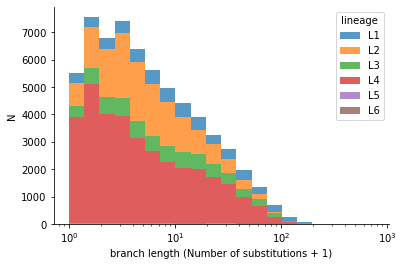

In [10]:
def extract_branch_lengths(t1):
    """
    Extracts branch lengths for each branch in the tree
    
    Parameters
    ----------
    t1: ete3.Tree
        the phylogeny of strains

    Returns
    -------
    list of tuples of (branch_name, float)

    """
    branch_names = []
    nodes = []

    for node in t1.traverse("levelorder"):
        if len(node.children) > 1:

            for idx, child_node in enumerate(node.children):
                name_anc = node.name.split("_")[0]
                name_des = child_node.name.split("_")[0]

                branch_name = f"{name_anc}-{name_des}"
                
                if name_des=='canettii':
                    #print("excluding canetti")
                    continue
                    
                branch_names.append(branch_name)
                nodes.append(node.dist)

    return branch_names, nodes

# Note: each tree is constructed from a different # of positions(the mutation concatenate for that lineage)
# So, to find the number of mutations per branch we must multliply by the # of mutated positions used to construct the tree

lineages = ["L1", "L2", "L3", "L4A", "L4B", "L4C", "L5", "L6"]
all_branch_lens = []
l_label = []
# extracts the branch length for each lineage and multiply by total # of muts. considered
for lineage in lineages: 
    
    print(lineage)
    # t1 = ete3.Tree(f"../newinput/{lineage}node_labelled_newick_cleaned.tre", format=1)
    t1 = ete3.Tree(f"input/{lineage}node_labelled_newick_cleaned.tre", format=1)
    b, n = extract_branch_lengths(t1)
    
    mutation_table = pd.read_csv(f"input/{lineage}all_mutation_events.tsv", sep="\t", low_memory=False)
    
    num_mutations = len(mutation_table.Position.unique())
    #print(lineage, num_mutations)
    n = np.array(n)
    n = n * num_mutations
    
    # This normalizes to mutation rate per genome
    #n = n / 4411532

    all_branch_lens += list(n)
    l_label += [lineage]*len(n)

data = pd.DataFrame({"length":all_branch_lens, "lineage":l_label})
# Add 1 to all branch lengths because some are length 0
data.length = data.length+1

## Plotting data with colors by lineage

data["lineage"] = ["L4" if "4" in x else x for x in data.lineage]
sns.histplot(data, x="length", hue="lineage", stat="count", 
             multiple="stack",log_scale=True, linewidth=0, bins=20)
plt.xlabel("branch length (Number of substitutions + 1)")
plt.ylabel("N")
sns.despine()
plt.savefig("figures/substitutions_per_genome_by_lineage.pdf")

## 1: Create Mutation Matrices for each lineage independently based on the respective tree

- Uses data previously computed by Roger Vargas using SNPPar
- Each lineage phylogeny was constructed independently. Lineage 4 was partitioned into three groups due to its large size

In [11]:
!mkdir output
!mkdir output/00.mutation_data_by_lineage
!mkdir output/00.mutation_data_by_lineage/Lineage1
!mkdir output/00.mutation_data_by_lineage/Lineage2
!mkdir output/00.mutation_data_by_lineage/Lineage3
!mkdir output/00.mutation_data_by_lineage/Lineage4A
!mkdir output/00.mutation_data_by_lineage/Lineage4B
!mkdir output/00.mutation_data_by_lineage/Lineage4C
!mkdir output/00.mutation_data_by_lineage/Lineage5
!mkdir output/00.mutation_data_by_lineage/Lineage6

mkdir: cannot create directory ‘output’: File exists
mkdir: cannot create directory ‘output/00.mutation_data_by_lineage’: File exists
mkdir: cannot create directory ‘output/00.mutation_data_by_lineage/Lineage1’: File exists
mkdir: cannot create directory ‘output/00.mutation_data_by_lineage/Lineage2’: File exists
mkdir: cannot create directory ‘output/00.mutation_data_by_lineage/Lineage3’: File exists
mkdir: cannot create directory ‘output/00.mutation_data_by_lineage/Lineage4A’: File exists
mkdir: cannot create directory ‘output/00.mutation_data_by_lineage/Lineage4B’: File exists
mkdir: cannot create directory ‘output/00.mutation_data_by_lineage/Lineage4C’: File exists
mkdir: cannot create directory ‘output/00.mutation_data_by_lineage/Lineage5’: File exists
mkdir: cannot create directory ‘output/00.mutation_data_by_lineage/Lineage6’: File exists


In [12]:
prefix = "output/00.mutation_data_by_lineage/Lineage1/L1"

ancestral_file="input/MTB_ancestor_reference_modified.fasta"

# Read in the phylogenetic tree
t1 = ete3.Tree(f"input/L1node_labelled_newick_cleaned.tre", format=1)

print("Number of branches:", len(t1.get_edges()))
print("Number of tips:", len(t1.get_leaves()))

# Read in concatenated SNP sequences used to do ASR on phylogeny
aln = Alignment.from_file(open(f"input/L1node_sequences.fasta",'r'))

# Read in table of all mutation events from SNPPar
mutation_table = pd.read_csv(f"input/L1all_mutation_events.tsv", sep="\t")
print("Number of unique mutations:", len(mutation_table.Position.unique()))
print("Number of mutations:", len(mutation_table))

# Count homoplasies on phylogeny relative to ancestral sequence
lineage = 1
ha = HomoplasyAnalysis(mutation_table, t1, lineage, ancestral_file, aln)
ha.mutation_event_matrix = ha.create_mutation_matrix(mode="mutation")
ha.reversion_matrix = ha.create_mutation_matrix(mode="reversion")
ha.background_matrix = ha.create_background_matrix()

# Save data
ha.dump_sparse(prefix)

Number of branches: 5630
Number of tips: 2816


/tmp/ipykernel_30924/2934379494.py:15: DtypeWarning: Columns (7,8,9,16,17,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  mutation_table = pd.read_csv(f"input/L1all_mutation_events.tsv", sep="\t")


Number of unique mutations: 189040
Number of mutations: 204695


In [13]:
old_mutation_table = pd.read_csv("../../newRepo/DependentMutations/input/L1all_mutation_events_checked_against_seqs.tsv", sep="\t")
len(old_mutation_table)

/tmp/ipykernel_30924/1369222226.py:1: DtypeWarning: Columns (7,8,9,16,17,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  old_mutation_table = pd.read_csv("../../newRepo/DependentMutations/input/L1all_mutation_events_checked_against_seqs.tsv", sep="\t")


204248

In [14]:
prefix = "output/00.mutation_data_by_lineage/Lineage2/L2"

ancestral_file="input/MTB_ancestor_reference_modified.fasta"

# Read in the phylogenetic tree
t1 = ete3.Tree(f"input/L2node_labelled_newick_cleaned.tre", format=1)
print("Number of branches:", len(t1.get_edges()))
print("Number of tips:", len(t1.get_leaves()))

# Read in concatenated SNP sequences used to do ASR on phylogeny
aln = Alignment.from_file(open(f"input/L2node_sequences.fasta",'r'))

# Read in table of all mutation events from SNPPar
mutation_table = pd.read_csv(f"input/L2all_mutation_events.tsv", sep="\t")
print("Number of unique mutations:", len(mutation_table.Position.unique()))

# Count homoplasies on phylogeny relative to ancestral sequence
lineage = 2
ha = HomoplasyAnalysis(mutation_table, t1, lineage, ancestral_file, aln)
ha.mutation_event_matrix = ha.create_mutation_matrix(mode="mutation")
ha.reversion_matrix = ha.create_mutation_matrix(mode="reversion")
ha.background_matrix = ha.create_background_matrix()

# Save data
ha.dump_sparse(prefix)

Number of branches: 16180
Number of tips: 8091


/tmp/ipykernel_30924/509732897.py:14: DtypeWarning: Columns (7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  mutation_table = pd.read_csv(f"input/L2all_mutation_events.tsv", sep="\t")


Number of unique mutations: 155809


In [15]:
prefix = "output/00.mutation_data_by_lineage/Lineage3/L3"

ancestral_file="input/MTB_ancestor_reference_modified.fasta"

# Read in the phylogenetic tree
t1 = ete3.Tree(f"input/L3node_labelled_newick_cleaned.tre", format=1)
print("Number of branches:", len(t1.get_edges()))
print("Number of tips:", len(t1.get_leaves()))

# Read in concatenated SNP sequences used to do ASR on phylogeny
aln = Alignment.from_file(open(f"input/L3node_sequences.fasta",'r'))

# Read in table of all mutation events from SNPPar
mutation_table = pd.read_csv(f"input/L3all_mutation_events.tsv", sep="\t")
print("Number of unique mutations:", len(mutation_table.Position.unique()))

# Count homoplasies on phylogeny relative to ancestral sequence
lineage = 3
ha = HomoplasyAnalysis(mutation_table, t1, lineage, ancestral_file, aln)
ha.mutation_event_matrix = ha.create_mutation_matrix(mode="mutation")
ha.reversion_matrix = ha.create_mutation_matrix(mode="reversion")
ha.background_matrix = ha.create_background_matrix()

# Save data
ha.dump_sparse(prefix)

Number of branches: 6796
Number of tips: 3399


/tmp/ipykernel_30924/3882852268.py:14: DtypeWarning: Columns (7,8,9,16,17,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  mutation_table = pd.read_csv(f"input/L3all_mutation_events.tsv", sep="\t")


Number of unique mutations: 128623


In [16]:
prefix = "output/00.mutation_data_by_lineage/Lineage4A/L4A"

ancestral_file="input/MTB_ancestor_reference_modified.fasta"

# Read in the phylogenetic tree
t1 = ete3.Tree(f"input/L4Anode_labelled_newick_cleaned.tre", format=1)
print("Number of branches:", len(t1.get_edges()))
print("Number of tips:", len(t1.get_leaves()))

# Read in concatenated SNP sequences used to do ASR on phylogeny
aln = Alignment.from_file(open(f"input/L4Anode_sequences.fasta",'r'))

# Read in table of all mutation events from SNPPar
mutation_table = pd.read_csv(f"input/L4Aall_mutation_events.tsv", sep="\t")
print("Number of unique mutations:", len(mutation_table.Position.unique()))

# Count homoplasies on phylogeny relative to ancestral sequence
lineage = '4A'
ha = HomoplasyAnalysis(mutation_table, t1, lineage, ancestral_file, aln)
ha.mutation_event_matrix = ha.create_mutation_matrix(mode="mutation")
ha.reversion_matrix = ha.create_mutation_matrix(mode="reversion")
ha.background_matrix = ha.create_background_matrix()

# Save data
ha.dump_sparse(prefix)

Number of branches: 11678
Number of tips: 5840


/tmp/ipykernel_30924/3416117973.py:14: DtypeWarning: Columns (7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  mutation_table = pd.read_csv(f"input/L4Aall_mutation_events.tsv", sep="\t")


Number of unique mutations: 140430


In [17]:
prefix = "output/00.mutation_data_by_lineage/Lineage4B/L4B"

ancestral_file="input/MTB_ancestor_reference_modified.fasta"

# Read in the phylogenetic tree
t1 = ete3.Tree(f"input/L4Bnode_labelled_newick_cleaned.tre", format=1)
print("Number of branches:", len(t1.get_edges()))
print("Number of tips:", len(t1.get_leaves()))

# Read in concatenated SNP sequences used to do ASR on phylogeny
aln = Alignment.from_file(open(f"input/L4Bnode_sequences.fasta",'r'))

# Read in table of all mutation events from SNPPar
mutation_table = pd.read_csv(f"input/L4Ball_mutation_events.tsv", sep="\t")
print("Number of unique mutations:", len(mutation_table.Position.unique()))

# Count homoplasies on phylogeny relative to ancestral sequence
lineage = '4B'
ha = HomoplasyAnalysis(mutation_table, t1, lineage, ancestral_file, aln)
ha.mutation_event_matrix = ha.create_mutation_matrix(mode="mutation")
ha.reversion_matrix = ha.create_mutation_matrix(mode="reversion")
ha.background_matrix = ha.create_background_matrix()

# Save data
ha.dump_sparse(prefix)

Number of branches: 13914
Number of tips: 6958


/tmp/ipykernel_30924/1034920307.py:14: DtypeWarning: Columns (7,8,9,16,17,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  mutation_table = pd.read_csv(f"input/L4Ball_mutation_events.tsv", sep="\t")


Number of unique mutations: 126238


In [18]:
prefix = "output/00.mutation_data_by_lineage/Lineage4C/L4C"

ancestral_file="input/MTB_ancestor_reference_modified.fasta"

# Read in the phylogenetic tree
t1 = ete3.Tree(f"input/L4Cnode_labelled_newick_cleaned.tre", format=1)
print("Number of branches:", len(t1.get_edges()))
print("Number of tips:", len(t1.get_leaves()))

# Read in concatenated SNP sequences used to do ASR on phylogeny
aln = Alignment.from_file(open(f"input/L4Cnode_sequences.fasta",'r'))

# Read in table of all mutation events from SNPPar
mutation_table = pd.read_csv(f"input/L4Call_mutation_events.tsv", sep="\t")
print("Number of unique mutations:", len(mutation_table.Position.unique()))

# Count homoplasies on phylogeny relative to ancestral sequence
lineage = '4C'
ha = HomoplasyAnalysis(mutation_table, t1, lineage, ancestral_file, aln)
ha.mutation_event_matrix = ha.create_mutation_matrix(mode="mutation")
ha.reversion_matrix = ha.create_mutation_matrix(mode="reversion")
ha.background_matrix = ha.create_background_matrix()

# Save data
ha.dump_sparse(prefix)

Number of branches: 8268
Number of tips: 4135


/tmp/ipykernel_30924/2790187550.py:14: DtypeWarning: Columns (7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  mutation_table = pd.read_csv(f"input/L4Call_mutation_events.tsv", sep="\t")


Number of unique mutations: 142165


In [25]:
prefix = "output/00.mutation_data_by_lineage/Lineage5/L5"

ancestral_file="input/MTB_ancestor_reference_modified.fasta"

# Read in the phylogenetic tree
t1 = ete3.Tree(f"input/L5node_labelled_newick_cleaned.tre", format=1)
print("Number of branches:", len(t1.get_edges()))
print("Number of tips:", len(t1.get_leaves()))

# Read in concatenated SNP sequences used to do ASR on phylogeny
aln = Alignment.from_file(open(f"input/L5node_sequences.fasta",'r'))

# Read in table of all mutation events from SNPPar
mutation_table = pd.read_csv(f"input/L5all_mutation_events.tsv", sep="\t")
print("Number of unique mutations:", len(mutation_table.Position.unique()))

# Count homoplasies on phylogeny relative to ancestral sequence
lineage = '5'
ha = HomoplasyAnalysis(mutation_table, t1, lineage, ancestral_file, aln)
ha.mutation_event_matrix = ha.create_mutation_matrix(mode="mutation")
ha.reversion_matrix = ha.create_mutation_matrix(mode="reversion")
ha.background_matrix = ha.create_background_matrix()

# Save data
ha.dump_sparse(prefix)

Number of branches: 196
Number of tips: 99
Number of unique mutations: 8692


In [26]:
prefix = "output/00.mutation_data_by_lineage/Lineage6/L6"

ancestral_file="input/MTB_ancestor_reference_modified.fasta"

# Read in the phylogenetic tree
t1 = ete3.Tree(f"input/L6node_labelled_newick_cleaned.tre", format=1)
print("Number of branches:", len(t1.get_edges()))
print("Number of tips:", len(t1.get_leaves()))

# Read in concatenated SNP sequences used to do ASR on phylogeny
aln = Alignment.from_file(open(f"input/L6node_sequences.fasta",'r'))

# Read in table of all mutation events from SNPPar
mutation_table = pd.read_csv(f"input/L6all_mutation_events.tsv", sep="\t")
print("Number of unique mutations:", len(mutation_table.Position.unique()))

# Count homoplasies on phylogeny relative to ancestral sequence
lineage = '6'
ha = HomoplasyAnalysis(mutation_table, t1, lineage, ancestral_file, aln)
ha.mutation_event_matrix = ha.create_mutation_matrix(mode="mutation")
ha.reversion_matrix = ha.create_mutation_matrix(mode="reversion")
ha.background_matrix = ha.create_background_matrix()

# Save data
ha.dump_sparse(prefix)

Number of branches: 192
Number of tips: 97
Number of unique mutations: 11271


## Determine mutations to examine based on number of evolutionary events

In [21]:
mutation_table = pd.read_csv(f"input/L1all_mutation_events.tsv", sep="\t")
t1 = mutation_table.groupby("Position").size()

mutation_table = pd.read_csv(f"input/L2all_mutation_events.tsv", sep="\t")
t2 = mutation_table.groupby("Position").size()

mutation_table = pd.read_csv(f"input/L3all_mutation_events.tsv", sep="\t")
t3 = mutation_table.groupby("Position").size()

mutation_table = pd.read_csv(f"input/L4Aall_mutation_events.tsv", sep="\t")
t4a = mutation_table.groupby("Position").size()

mutation_table = pd.read_csv(f"input/L4Ball_mutation_events.tsv", sep="\t")
t4b = mutation_table.groupby("Position").size()

mutation_table = pd.read_csv(f"input/L4Call_mutation_events.tsv", sep="\t")
t4c = mutation_table.groupby("Position").size()

mutation_table = pd.read_csv(f"input/L5all_mutation_events.tsv", sep="\t")
t5 = mutation_table.groupby("Position").size()

mutation_table = pd.read_csv(f"input/L6all_mutation_events.tsv", sep="\t")
t6 = mutation_table.groupby("Position").size()


t = pd.DataFrame({
    "L1": t1,
    "L2": t2,
    "L3": t3,
    "L4A": t4a,
    "L4B": t4b,
    "L4C": t4c,
    "L5": t5,
    "L6": t6,
})
t = t.fillna(0)
t["summed"] = t.sum(axis=1)

t.to_csv("output/00.mutation_data_by_lineage/event_frequency_table.csv")

/tmp/ipykernel_30924/3305117556.py:1: DtypeWarning: Columns (7,8,9,16,17,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  mutation_table = pd.read_csv(f"input/L1all_mutation_events.tsv", sep="\t")
/tmp/ipykernel_30924/3305117556.py:4: DtypeWarning: Columns (7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  mutation_table = pd.read_csv(f"input/L2all_mutation_events.tsv", sep="\t")
/tmp/ipykernel_30924/3305117556.py:7: DtypeWarning: Columns (7,8,9,16,17,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  mutation_table = pd.read_csv(f"input/L3all_mutation_events.tsv", sep="\t")
/tmp/ipykernel_30924/3305117556.py:10: DtypeWarning: Columns (7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  mutation_table = pd.read_csv(f"input/L4Aall_mutation_events.tsv", sep="\t")
/tmp/ipykernel_30924/3305117556.py:13: DtypeWarning: Columns (7,8,9,16,17,19,20) have mixed types.

## Combine mutation matrices for each lineage into final matrix

In [6]:
def create_matrix(prefixes, matrix_name, all_branches, positions):
    """
    Creates an N_branches x N_positions matrix tracking evolution on all the trees
    
    Parameters
    ----------
    prefixes: list of str
        list of prefixes containing the lineage-specific data
    matrix_name: str
        prefix indicating which matrix to load
        current options are mutation_matrix, background_matrix, and reversion_matrix
    all_branches: list of str
    
    positions: list of int
    """

    full_positions_to_index = {x:idx for idx,x in enumerate(positions)}
    print("Number of positions after 5 event filtered", len(full_positions_to_index))
    
    # Initialize the N_branches x N_positions matrix
    full_mutation_matrix = np.zeros(shape=(len(all_branches), len(filtered_positions)),dtype='int8')
    print("initialized matrix with shape:", full_mutation_matrix.shape)

    # For each lineage sub-tree
    for prefix in prefixes:

        #Load in the branches from current lineage and get their indices in the full matrix
        branches = np.load(f"{prefix}_branches.npy")
        branches_start_index = all_branches.index(branches[0])
        branches_end_index= all_branches.index(branches[-1])

        #Load in the positions found to be mutated in current lineage
        positions_in_lineage = list(np.load(f"{prefix}_positions.npy"))
        positions_in_lineage_to_index = {x:idx for idx,x in enumerate(positions_in_lineage)}

        #Load in the matrix and condense
        matrix = sparse.load_npz(f"{prefix}_{matrix_name}.npz").toarray()
        matrix = matrix.astype("int8")
        print(f"{prefix} matrix has shape {matrix.shape}")

        # Find intersection between positions found in current lineage and full matrix (which has been pre-filtered for frequency)
        test_set = set(positions)
        filtered_positions_in_lineage = [x for x in positions_in_lineage if x in test_set]
        print(f"{len(filtered_positions_in_lineage)} positions in the {prefix} matrix are found in the full matrix")

        # Find the indices
        mutation_matrix_index = np.array([positions_in_lineage_to_index[pos] for pos in filtered_positions_in_lineage])
        full_mutation_matrix_index = np.array([full_positions_to_index[pos] for pos in filtered_positions_in_lineage])

        # Assert that indices are both in ascending order -> otherwise, results will be wrong
        assert(list(mutation_matrix_index) == sorted(list(mutation_matrix_index)))
        assert(list(full_mutation_matrix_index) == sorted(list(full_mutation_matrix_index)))

        # fill in the branch, positions in the full matrix corresponding to current lineage matrix
        full_mutation_matrix[branches_start_index:branches_end_index + 1,:][:,full_mutation_matrix_index] = matrix[:,mutation_matrix_index]

    return full_mutation_matrix


In [3]:
!mkdir output/00.mutation_data_by_lineage/00.combined_data

prefixes =  [
    "output/00.mutation_data_by_lineage/Lineage1/L1", 
    "output/00.mutation_data_by_lineage/Lineage2/L2", 
    "output/00.mutation_data_by_lineage/Lineage3/L3", 
    "output/00.mutation_data_by_lineage/Lineage4A/L4A",
    "output/00.mutation_data_by_lineage/Lineage4B/L4B",
    "output/00.mutation_data_by_lineage/Lineage4C/L4C", 
    "output/00.mutation_data_by_lineage/Lineage5/L5", 
    "output/00.mutation_data_by_lineage/Lineage6/L6"]

# Get a list of all the branches across all the trees
all_branches = []

for prefix in prefixes:
    branches = np.load(f"{prefix}_branches.npy")
    
    all_branches = all_branches + list(branches)



mkdir: cannot create directory ‘output/00.mutation_data_by_lineage/00.combined_data’: File exists


In [4]:

# Get a list of all positions to be used
filtered_positions = pd.read_csv("output/00.mutation_data_by_lineage/event_frequency_table.csv").query("summed > 4")
positions = list(filtered_positions.Position)

# Ensure that we've accurately filtered positions from Marin et al
ebr = pd.read_csv(
    "input/EBR.csv", index_col=0
)
filtered_positions = filtered_positions.merge(ebr, how="left", left_on="Position", right_on="position")
print("Number of positions before EBR filtering", len(filtered_positions))
filtered_positions = filtered_positions.query("EBR >= 0.9")
print("Number of positions after EBR filtering", len(filtered_positions))

# Accurately filter the positions from Modlin et al
modlin = pd.read_csv("input/S7-seq-attributes.csv")
blindspots = modlin.query("blindspot==1")
blindspot_list = list(blindspots.rv_position)
filtered_positions = filtered_positions.query("not Position in @blindspot_list")
print("Number of positions after blindspot filtering", len(filtered_positions))

positions = list(filtered_positions.Position)

Number of positions before EBR filtering 5589
Number of positions after EBR filtering 5543
Number of positions after blindspot filtering 5489


In [7]:

np.save("output/00.mutation_data_by_lineage/00.combined_data/all_positions_5strain_filtering.npy", np.array(positions))
np.save("output/00.mutation_data_by_lineage/00.combined_data/all_branches.npy", np.array(all_branches))

mutation_matrix = create_matrix(prefixes, "mutation_matrix", all_branches, positions)
np.save("output/00.mutation_data_by_lineage/00.combined_data/all_mutation_matrix_5strain_filtering.npy", mutation_matrix)

background_matrix =  create_matrix(prefixes, "background_matrix", all_branches, positions)
np.save("output/00.mutation_data_by_lineage/00.combined_data/all_background_matrix_5strain_filtering.npy", background_matrix)

reversion_matrix =  create_matrix(prefixes, "reversion_matrix", all_branches, positions)
np.save("output/00.mutation_data_by_lineage/00.combined_data/all_reversion_matrix_5strain_filtering.npy", reversion_matrix)

Number of positions after 5 event filtered 5489
initialized matrix with shape: (62846, 5489)
output/00.mutation_data_by_lineage/Lineage1/L1 matrix has shape (5629, 189040)
2937 positions in the output/00.mutation_data_by_lineage/Lineage1/L1 matrix are found in the full matrix
output/00.mutation_data_by_lineage/Lineage2/L2 matrix has shape (16179, 155809)
4069 positions in the output/00.mutation_data_by_lineage/Lineage2/L2 matrix are found in the full matrix
output/00.mutation_data_by_lineage/Lineage3/L3 matrix has shape (6795, 128623)
2779 positions in the output/00.mutation_data_by_lineage/Lineage3/L3 matrix are found in the full matrix
output/00.mutation_data_by_lineage/Lineage4A/L4A matrix has shape (11677, 140430)
3306 positions in the output/00.mutation_data_by_lineage/Lineage4A/L4A matrix are found in the full matrix
output/00.mutation_data_by_lineage/Lineage4B/L4B matrix has shape (13913, 126238)
3109 positions in the output/00.mutation_data_by_lineage/Lineage4B/L4B matrix are f